# Variable-step integration of chaotic systems

Preamble: Run the cells below to import the necessary Python packages

<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/integrator_chaos_variable_step.ipynb) -->
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/integrator_chaos_variable_step.ipynb)

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

In [7]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline




Previously, we encountered fixed-step integrators, which take steps towards the solution of an initial value problem using a fixed time step $\Delta t$. In this notebook, we will explore variable-step integrators, which take steps of varying size to achieve a desired accuracy.


### Relationship to optimization

In optimization, we saw second-order methods like Newton's method, in which the gradient descent step scales inversely with the local concavity. In numerical integration, we will see methods that scale inversely with the local smoothness. This is a common theme in numerical methods: we want to take steps that are inversely proportional to the local smoothness of the problem.

### The Hadley Cell model

As our toy system for today's notebook, we will use the low-order Hadley cell model, which is derived from the coupled dynamics of atomospheric temperature and water vapor. The model consists of three coupled ordinary differential equations (ODEs), each of which describes the rate of change of temperature, water vapor, and wind speed.

Before implementing our own variable-step methods, we'll start by generating a reference trajectory using an existing integrator `scipy.solve_ivp`

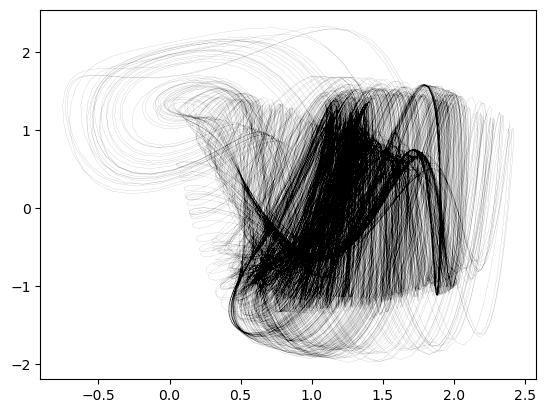

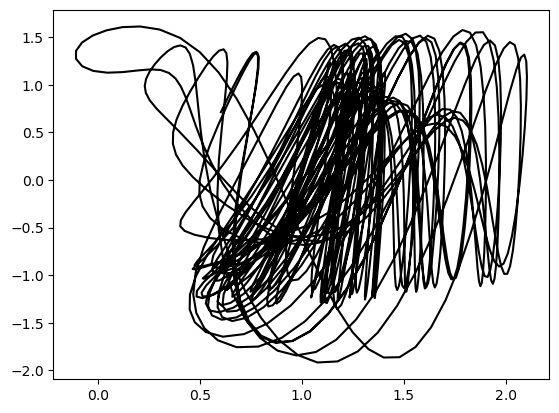

In [8]:
class Hadley:

    def __init__(self, a=0.2, b=4, f=9, g=1):
        self.a = a
        self.b = b
        self.f = f
        self.g = g
        self.name = self.__class__.__name__

    def rhs(self, t, X):
        x, y, z = X
        xdot = -(y ** 2) - z ** 2 - self.a * x + self.a * self.f
        ydot = x * y - self.b * x * z - y + self.g
        zdot = self.b * x * y + x * z - z
        return np.array([xdot, ydot, zdot])
    
    def __call__(self, t, X):
        return self.rhs(t, X)


from scipy.integrate import solve_ivp
ic = np.array([1.37, 0.93, 0.64])

hadley = Hadley()
sol = solve_ivp(hadley, [0, 2000], ic, method='RK45', rtol=1e-6, atol=1e-6)

plt.figure()
plt.plot(sol.y[0], sol.y[1], color='k', linewidth=0.05)


plt.figure()
sol = solve_ivp(hadley, [0, 100], ic, method='RK45', rtol=1e-6, atol=1e-6)
plt.plot(sol.y[0], sol.y[1],  color='k')


## Variable-step methods

Previously, we solved the initial value problem

$$
\begin{align}
\dot{\mathbf{x}}(t) &= \mathbf{f}(t, \mathbf{x}(t)) \\
\mathbf{x}(t_0) &= \mathbf{x}_0
\end{align}
$$

by taking steps of size $\Delta t$ in time, for example by using the Euler method,

$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{f}(t_n, \mathbf{x}_n)
$$

We will instead add an additional update step to the Euler method, which will allow us to take steps of varying size. This is reminiscent of our optimization module, where for certain methods we changed the learning rate adaptively in each step.

### Euler's method with a variable step size

Recall that we defined the error in terms of the error introduced into our integration solution by taking a single step of size $\Delta t$,

$$
\begin{align}
\mathbf{e}_n &= \mathbf{x}(t_n) - \mathbf{x}_n \\
&= \mathbf{x}(t_n) - \mathbf{x}_{n -1} - \Delta t \, \mathbf{f}(t_{n -1}, \mathbf{x}_{n-1})
\end{align}
$$
where $\mathbf{x}(t_n)$ is the exact solution at time $t_n$. The local error corresponds to the error introduced by taking a single step of size $\Delta t$,





### How do we reduce the error?

In principle, we can always reduce the error of our integration by taking a smaller step size $\Delta t$. But how much should we decrease $\Delta t$? We can use the local error to determine this. At each step, we compute an estimate of the local error $\mathbf{e}_n$ by comparing our current solution $\mathbf{x}_n$ to solution we would have arrived at if we had instead taken two half steps of size $\Delta t/2$.

We call this approximate local error estimate $\tilde{\mathbf{e}}_n$,

We consider the full Euler update,
$$
    \mathbf{x}_{n}^{\text{full}} \equiv \mathbf{x}_{n -1} + \Delta t \, \mathbf{f}(t_{n -1}, \mathbf{x}_{n-1})
$$
and the half-step update,
$$
    \mathbf{x}_{n}^{\text{two half}} \equiv \mathbf{x}_{n - 1/2}^{\text{half}} + \frac{\Delta t}{2} \, \mathbf{f}(t_{n -1/2}, \mathbf{x}_{n-1/2}^{\text{half}}); \quad \mathbf{x}_{n - 1/2}^{\text{half}} \equiv \mathbf{x}_{n -1} + \frac{\Delta t}{2} \, \mathbf{f}(t_{n -1}, \mathbf{x}_{n-1})
$$

At each step, we perform these two updates (a total of three evaluations of $\mathbf{f}$) and compute the error estimate,

$$
\tilde{\mathbf{e}}_n = \mathbf{x}_{n}^{\text{two half}} -\mathbf{x}_{n}^{\text{full}}
$$

We define a cutoff $||\tilde{\mathbf{e}}_n ||$ known as the relative tolerance, $r$. If our error is below this threshold, then we accept the full step at the current value of $\Delta t$. If the error exceeds this number, then instead we update our step size $\Delta t$ at a rate proportional to the error $||\tilde{\mathbf{e}}_n ||$

$$
\Delta t_{n+1} = \Delta t_n \, 0.9 \,\bigg(\frac{r}{\|\tilde{\mathbf{e}}_n\|}\bigg)^{1/2}
$$

The factor of $r$ ensures that we do not take steps that are too small, and the factor of $\|\tilde{\mathbf{e}}_n\|$ ensures that we do not take steps that are too large. The $0.9$ factor is a safety factor to ensure that we do not take steps that are too large.





In [ ]:
class BaseAdaptiveIntegrator:
    """A base class for adaptive numerical integrators"""

    def __init__(self, dt=1e-3, rtol=1e-2, max_iter=1e8, safety_factor=0.9):
        self.dt = dt
        self.name = self.__class__.__name__
        self.rtol = rtol
        self.max_iter = max_iter
        self.safety_factor = safety_factor

    def integrate(self, f, tspan, y):
        """Integrate the system using the Euler method"""
        
        dt_init = self.dt
        y_vals = [y.copy()]
        t = tspan[0]
        t_vals = [t]
        num_iter = 0

        ## Keep updating the state until we reach the target time
        while t < tspan[-1]:

            ## Steppers implemented in child classes
            y_coarse, y_fine = self.update(f, t, y_vals[-1])

            ## Error estimate
            err = np.linalg.norm(y_coarse - y_fine)

            ## Accept step if error is small enough
            if err < self.rtol:
                t += self.dt
                y_vals.append(y_fine)
                t_vals.append(t)
                self.dt = dt_init

            ## Otherwise, reduce step size
            else:
                self.dt *= self.safety_factor * np.sqrt(self.rtol / err)

            if num_iter > self.max_iter:
                print("Max iterations reached")
                break


        self.t, self.y = np.array(t_vals), np.array(y_vals)
        return self
    
    def update(self, f, t, y):
        """
        Update the solution using the integration scheme implemented in the child class
        """
        raise NotImplementedError
        

class EulerTwoStep(BaseAdaptiveIntegrator):

    def update(self, f, t, y):
        """Update the solution using the explicit Euler method"""

        ## Euler step
        y_next = y + self.dt * f(t, y)

        ## Euler step with half step
        y_half = y + 0.5 * self.dt * f(t, y)
        y_next_half = y_half + 0.5 * self.dt * f(t + 0.5 * self.dt, y_half)

        return y_next, y_next_half

## Compare two-step adaptive Euler to a built-in adaptive integrator

Text(0.5, 1.0, 'Scipy')

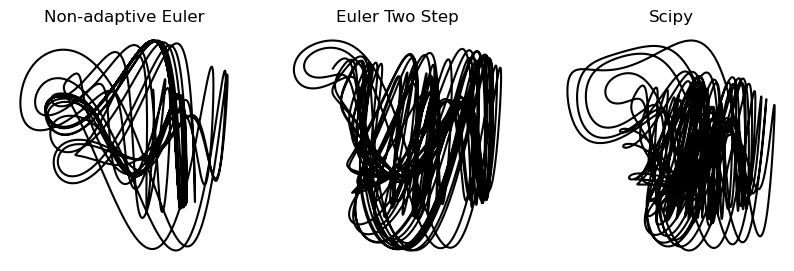

In [10]:
plt.figure(figsize=(10, 3))
integrator = EulerTwoStep(dt=1e-2, rtol=1e10)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 3, 1)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.axis('off')
plt.title("Non-adaptive Euler")

integrator = EulerTwoStep(dt=1e-2, rtol=1e-7)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 3, 2)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.axis('off')
plt.title("Euler Two Step")

plt.subplot(1, 3, 3)
sol = solve_ivp(hadley, [0, 100], ic, method='Radau', rtol=1e-6, atol=1e-6)
plt.plot(sol.y[0], sol.y[1],  color='k')
plt.axis('off')
plt.title("Scipy")

We can see that the Hadley solution changes considerably with the integration strategy, suggesting that the chaotic nature of this system makes it very sensitive to small errors. However, the two-step Euler method captures more detail in the attractor, such as the slow spiral in the upper left corner.

We can monitor the step size of the two methods during integration, to see when the adaptive Euler needed to take a smaller step.

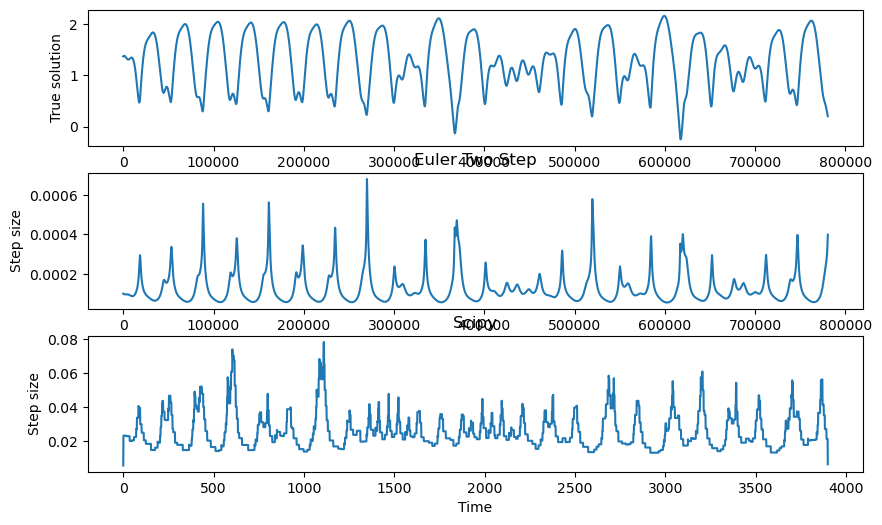

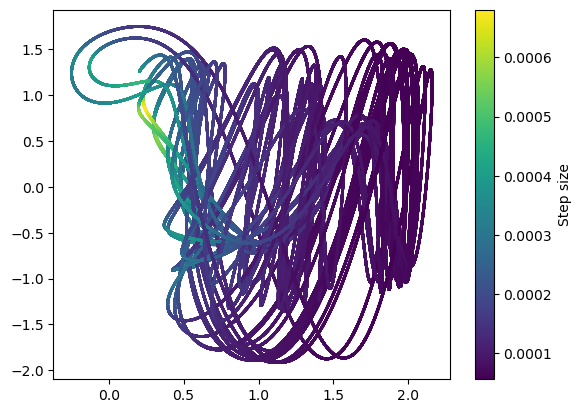

In [11]:
plt.figure(figsize=(10, 6))


plt.subplot(3, 1, 1)
plt.plot(integrator.y[:, 0])
plt.xlabel("Time")
plt.ylabel("True solution")
# plt.title("Euler Two Step")

plt.subplot(3, 1, 2)
plt.plot(np.diff(integrator.t))
plt.xlabel("Time")
plt.ylabel("Step size")
plt.title("Euler Two Step")

plt.subplot(3, 1, 3)
plt.plot(np.diff(sol.t))
plt.xlabel("Time")
plt.ylabel("Step size")
plt.title("Scipy")


plt.figure()
plt.scatter(integrator.y[:-1, 0], integrator.y[:-1, 1],  c=np.diff(integrator.t), s=1)
plt.colorbar(label="Step size")

It looks like the adaptive integrators both take smaller steps when the dynamics are moving quickly. This makes sense, because the derivative has units that are inverse to time. In fixed-step integration, we saw that the convergence of an integration scheme on a given system depended on the Lipschitz constant of the system, which measures the size of the derivative across the domain. With variable step methods, we can locally adapt the step size rather than needing to pick a global step size based on the Lipschitz constant.

## Some things to try

+ Try varying the relative tolerance $\epsilon$ and the initial step size $\Delta t_0$ and see how the solution changes.

+ What are some drawbacks of the two-step Euler method? How might we improve it?

<br><br><br><br><br><br><br>

## Embedded methods

The Runge-Kutta-Fehlberg method is a variable-step method that is *embedded*, meaning that it is a pair of methods where one is more accurate than the other. We can think of embedded methods as generalizing the idea of computing a regular step and a half step to estimate local error in Euler's method. The Butcher tableau for embedded methods contain *two* different methods, one of which is the higher-order method, and the other is the lower-order method. These methods are directly compared in order to estimate the error at each step and then adapt the step size.

The embedded version of Runge-Kutta 4(5) is given by

<!-- $$
\begin{align}
\mathbf{k}_1 &= \Delta t \, \mathbf{f}(t_n, \mathbf{x}_n) \\
\mathbf{k}_2 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\mathbf{k}_1}{4}) \\
\mathbf{k}_3 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\mathbf{k}_1}{8} + \frac{\mathbf{k}_2}{8}) \\
\mathbf{k}_4 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{2}, \mathbf{x}_n - \frac{\mathbf{k}_2}{2} + \mathbf{k}_3) \\
\mathbf{k}_5 &= \Delta t \, \mathbf{f}(t_n + \frac{3 \Delta t}{4}, \mathbf{x}_n + \frac{3 \mathbf{k}_1}{16} + \frac{9 \mathbf{k}_4}{16}) \\
\mathbf{k}_6 &= \Delta t \, \mathbf{f}(t_n + \Delta t, \mathbf{x}_n - \frac{3 \mathbf{k}_1}{7} + \frac{2 \mathbf{k}_2}{7} + \frac{12 \mathbf{k}_3}{7} - \frac{12 \mathbf{k}_4}{7} + \frac{8 \mathbf{k}_5}{7}) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{7 \mathbf{k}_1}{90} + \frac{32 \mathbf{k}_3}{90} + \frac{12 \mathbf{k}_4}{90} + \frac{32 \mathbf{k}_5}{90} + \frac{7 \mathbf{k}_6}{90} \\
\mathbf{y}_{n+1} &= \mathbf{x}_n + \frac{7 \mathbf{k}_1}{360} + \frac{32 \mathbf{k}_3}{360} + \frac{12 \mathbf{k}_4}{360} + \frac{32 \mathbf{k}_5}{360} + \frac{7 \mathbf{k}_6}{360}
\end{align}
$$

where $\mathbf{y}_{n+1}$ is the higher-order method, and $\mathbf{x}_{n+1}$ is the lower-order method. The error is given by -->


$$
\begin{align}
\mathbf{k}_1 &= \Delta t \, \mathbf{f}(t_n, \mathbf{x}_n) \\
\mathbf{k}_2 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\mathbf{k}_1}{4}) \\
\mathbf{k}_3 &= \Delta t \, \mathbf{f}(t_n + \frac{3\Delta t}{8}, \mathbf{x}_n + \frac{3\mathbf{k}_1}{32} + \frac{\mathbf{k}_2}{32}) \\
\mathbf{k}_4 &= \Delta t \, \mathbf{f}(t_n + \frac{12\Delta t}{13}, \mathbf{x}_n + \frac{1932\mathbf{k}_1}{2197} - \frac{7200\mathbf{k}_2}{2197} + \frac{7296\mathbf{k}_3}{2197}) \\
\mathbf{k}_5 &= \Delta t \, \mathbf{f}(t_n + \Delta t, \mathbf{x}_n + \frac{439\mathbf{k}_1}{216} - 8\mathbf{k}_2 + \frac{3680\mathbf{k}_3}{513} - \frac{845\mathbf{k}_4}{4104}) \\
\mathbf{k}_6 &= \Delta t \, \mathbf{f}(t_n + \frac{\Delta t}{2}, \mathbf{x}_n - \frac{8\mathbf{k}_1}{27} + 2\mathbf{k}_2 - \frac{3544\mathbf{k}_3}{2565} + \frac{1859\mathbf{k}_4}{4104} - \frac{11\mathbf{k}_5}{40}) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{25\mathbf{k}_1}{216} + \frac{1408\mathbf{k}_3}{2565} + \frac{2197\mathbf{k}_4}{4104} - \frac{\mathbf{k}_5}{5} \\
\mathbf{y}_{n+1} &= \mathbf{x}_n + \frac{16\mathbf{k}_1}{135} + \frac{6656\mathbf{k}_3}{12825} + \frac{28561\mathbf{k}_4}{56430} - \frac{9\mathbf{k}_5}{50} + \frac{2\mathbf{k}_6}{55}
\end{align}
$$

where $\mathbf{y}_{n+1}$ is the 5th order solution, and $\mathbf{x}_{n+1}$ is the 4th order solution. The Butcher tableau for this method is given by

$$
\begin{array}{c|cccccc}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & 0 & 0 & 0 & 0 & 0 \\
\frac{3}{8} & \frac{3}{32} & \frac{9}{32} & 0 & 0 & 0 & 0 \\
\frac{12}{13} & \frac{1932}{2197} & -\frac{7200}{2197} & \frac{7296}{2197} & 0 & 0 & 0 \\
1 & \frac{439}{216} & -8 & \frac{3680}{513} & -\frac{845}{4104} & 0 & 0 \\
\frac{1}{2} & -\frac{8}{27} & 2 & -\frac{3544}{2565} & \frac{1859}{4104} & -\frac{11}{40} & 0 \\
\hline
& \frac{25}{216} & 0 & \frac{1408}{2565} & \frac{2197}{4104} & -\frac{1}{5} & 0 \\
& \frac{16}{135} & 0 & \frac{6656}{12825} & \frac{28561}{56430} & -\frac{9}{50} & \frac{2}{55}
\end{array}
$$


Just like the two-step Euler method, we estimate the local (step-wise) truncation error by comparing the two solutions. The error estimate is given by

$$
\mathbf{e}_{n+1} = \mathbf{y}_{n+1} - \mathbf{x}_{n+1}
$$

The error is estimated by

$$
\mathcal{E} = \frac{1}{\Delta t} \left\| \mathbf{e}_{n+1} \right\|_2
$$

The error is then used to determine the next step size, $\Delta t_{n+1}$, by

$$
\Delta t_{n+1} = \Delta t \, (0.9)\left( \frac{\epsilon}{\mathcal{E}} \right)^{1/4}
$$

where $\epsilon$ is a desired accuracy. The step size is bounded by $\Delta t_{\text{min}}$ and $\Delta t_{\text{max}}$.

In [27]:
class RungeKuttaFehlberg(BaseAdaptiveIntegrator):

    def update(self, f, t, y):
        """Update the solution using the RKF45 method"""

        k1 = f(t, y)
        k2 = f(t + 0.25 * self.dt, y + 0.25 * self.dt * k1)
        k3 = f(t + 0.375 * self.dt, y + 0.09375 * self.dt * k1 + 0.28125 * self.dt * k2)
        k4 = f(t + 12/13 * self.dt, y + 1932/2197 * self.dt * k1 - 7200/2197 * self.dt * k2 + 7296/2197 * self.dt * k3)
        k5 = f(t + self.dt, y + 439/216 * self.dt * k1 - 8 * self.dt * k2 + 3680/513 * self.dt * k3 - 845/4104 * self.dt * k4)
        k6 = f(t + 0.5 * self.dt, y - 8/27 * self.dt * k1 + 2 * self.dt * k2 - 3544/2565 * self.dt * k3 + 1859/4104 * self.dt * k4 - 11/40 * self.dt * k5)

        y_next = y + self.dt * (25/216 * k1 + 1408/2565 * k3 + 2197/4104 * k4 - 1/5 * k5)
        y_next_half = y + self.dt * (16/135 * k1 + 6656/12825 * k3 + 28561/56430 * k4 - 9/50 * k5 + 2/55 * k6)

        return y_next, y_next_half

Text(0.5, 1.0, 'Scipy')

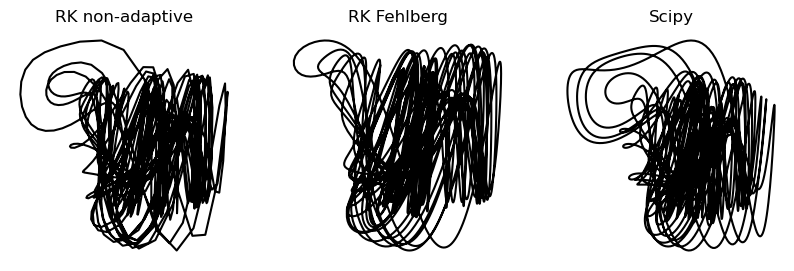

In [32]:
plt.figure(figsize=(10, 3))

integrator = RungeKuttaFehlberg(dt=1e-1, rtol=1e10)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 3, 1)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.axis('off')
plt.title("RK non-adaptive")


integrator = RungeKuttaFehlberg(dt=1e-1, rtol=1e-6)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 3, 2)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.axis('off')
plt.title("RK Fehlberg")


sol0 = solve_ivp(hadley, [0, 100], ic, method="Radau", rtol=1e-6, atol=1e-6, max_step=1e-1)
plt.subplot(1, 3, 3)
plt.plot(sol0.y[0], sol0.y[1],  color='k')
plt.axis('off')
plt.title("Scipy")

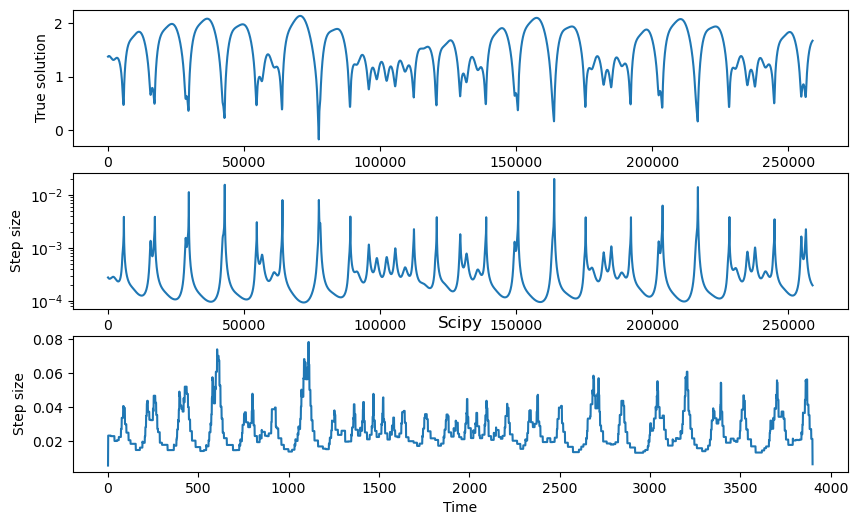

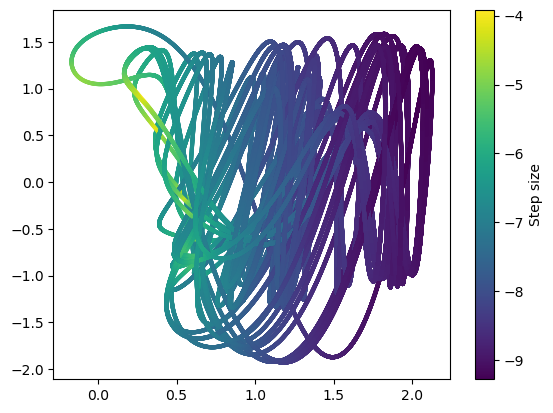

In [17]:
plt.figure(figsize=(10, 6))


plt.subplot(3, 1, 1)
plt.plot(integrator.y[:, 0])
plt.xlabel("Time")
plt.ylabel("True solution")

plt.subplot(3, 1, 2)
plt.semilogy(np.diff(integrator.t))
plt.xlabel("Time")
plt.ylabel("Step size")

plt.subplot(3, 1, 3)
plt.plot(np.diff(sol.t))
plt.xlabel("Time")
plt.ylabel("Step size")
plt.title("Scipy")


plt.figure()
plt.scatter(integrator.y[:-1, 0], integrator.y[:-1, 1],  c=np.log(np.diff(integrator.t)), s=4)
plt.colorbar(label="Step size")


## Dormand Prince

the Dormand-Prince method is a 7th order method with 8 stages, and is the default method used in `scipy.solve_ivp`.

In [19]:
class DormandPrince(BaseAdaptiveIntegrator):

    def update(self, f, t, y):
        """Update the solution using the DormandPrince method"""

        k1 = f(t, y)
        k2 = f(t + 1/5 * self.dt, y + 1/5 * self.dt * k1)
        k3 = f(t + 3/10 * self.dt, y + 3/40 * self.dt * k1 + 9/40 * self.dt * k2)
        k4 = f(t + 4/5 * self.dt, y + 44/45 * self.dt * k1 - 56/15 * self.dt * k2 + 32/9 * self.dt * k3)
        k5 = f(t + 8/9 * self.dt, y + 19372/6561 * self.dt * k1 - 25360/2187 * self.dt * k2 + 64448/6561 * self.dt * k3 - 212/729 * self.dt * k4)
        k6 = f(t + self.dt, y + 9017/3168 * self.dt * k1 - 355/33 * self.dt * k2 + 46732/5247 * self.dt * k3 + 49/176 * self.dt * k4 - 5103/18656 * self.dt * k5)
        k7 = f(t + self.dt, y + 35/384 * self.dt * k1 + 0 + 500/1113 * self.dt * k3 + 125/192 * self.dt * k4 - 2187/6784 * self.dt * k5 + 11/84 * self.dt * k6)

        y_next = y + self.dt * (35/384 * k1 + 0 + 500/1113 * k3 + 125/192 * k4 - 2187/6784 * k5 + 11/84 * k6)
        y_next_half = y + self.dt * (5179/57600 * k1 + 0 + 7571/16695 * k3 + 393/640 * k4 - 92097/339200 * k5 + 187/2100 * k6 + 1/40 * k7)

        return y_next, y_next_half


Text(0.5, 1.0, 'Scipy')

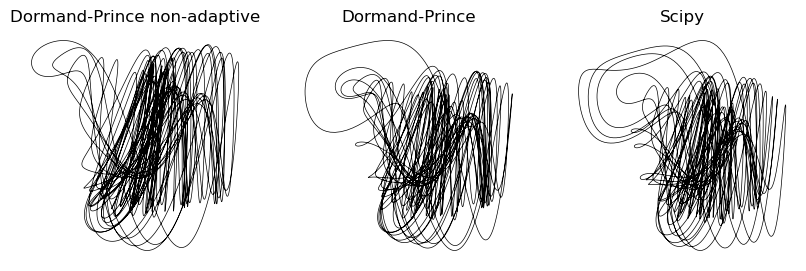

In [26]:
plt.figure(figsize=(10, 3))

integrator = DormandPrince(dt=1e-2, rtol=1e10)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 3, 1)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k', linewidth=0.5)
plt.axis('off')
plt.title("Dormand-Prince non-adaptive")


integrator = DormandPrince(dt=1e-1, rtol=1e-7)
integrator.integrate(hadley, [0, 100], ic)
plt.subplot(1, 3, 2)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k', linewidth=0.5)
plt.axis('off')
plt.title("Dormand-Prince")


sol0 = solve_ivp(hadley, [0, 100], ic, method='Radau', rtol=1e-6, atol=1e-6, max_step=1e-1)
plt.subplot(1, 3, 3)
plt.plot(sol0.y[0], sol0.y[1], color='k', linewidth=0.5)
plt.axis('off')
plt.title("Scipy")

We can see that using a higher-order method started to cause our implementation to align with the higher-resolution solution found by `scipy`. In particular, the loop in the upper left corner of the attractor is much more accurate.

<br><br><br><br><br><br><br>

# Stochastic differential equations

What if our differential equation has a stochastic component? We can use the same methods as before, but we need to take into account the non-deterministic nature of the right hand side. We will use the Euler-Maruyama method, which is a first-order method for stochastic differential equations. The method is given by

$$
    \begin{align}
    \mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t\; \mathbf{f}(\mathbf{x}_n) + \sqrt{\Delta t}\; g(\mathbf{x}_n) \xi_n \\
    \xi_n &\sim \mathcal{N}(0, 1)
    \end{align}
$$

Notice that this is similar to how we implemented Ornstein-Uhlenbeck dynamics in an earlier chapter. We replace the harmonic oscillator forcing with the general right hand side of the differential equation. Importantly, when discretizing a Brownian motion process, we scale our noise term by $\sqrt{\Delta t}$. This is because Brownian motion has a mean *square* displacement that scales as $\Delta t$, corresponding to the average distance from origin scaling as $\sqrt{t}$.

Additional discussion of more sophisticated methods for stochastic differential equations, as well as how the Ito and Stratonovich formulations of stochastic calculus differ, is available [here](https://math.gmu.edu/~tsauer/pre/sde.pdf).


Text(0.5, 1.0, 'Adaptive Euler-Maruyama')

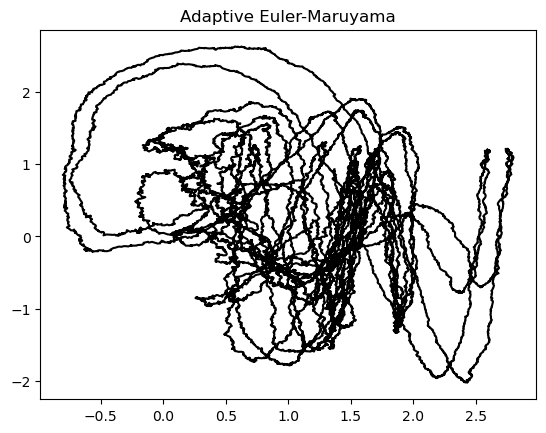

In [39]:
class AdaptiveEulerMaruyama(BaseAdaptiveIntegrator):

    def __init__(self, noise=1e-2, **kwargs):
        super().__init__(**kwargs)
        self.noise = noise

    def update(self, f, t, y):
        """Update the solution using the Euler-Maruyama method"""

        noise = self.noise * np.random.randn(*y.shape) * np.sqrt(self.dt)
        y_next = y + self.dt * f(t, y) + noise
        y_next_half = y + 0.5 * self.dt * f(t, y) + noise

        return y_next, y_next_half
    

integrator = AdaptiveEulerMaruyama(dt=1e-2, noise=1e-1)
integrator.integrate(hadley, [0, 100], ic)
plt.plot(integrator.y[:, 0], integrator.y[:, 1], color='k')
plt.title("Adaptive Euler-Maruyama")

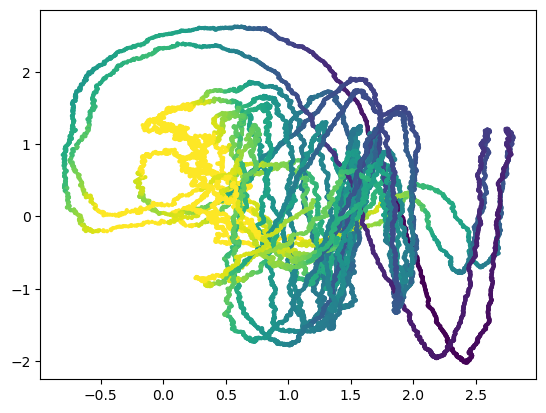

In [40]:
dt_vals = np.diff(integrator.t)
plt.scatter(integrator.y[1:, 0], integrator.y[1:, 1], c=np.log(dt_vals), s=4)

# Symplectic integration

Suppose that we want to integrate a system with an explicit conserved quantity, like a Hamiltonian physical system or a fluid dynamical system described by a stream function. Often, we want to build conservation directly into our integration scheme, to avoid errors from compounding at very long timescales. To demonstrate this, we will simulate the dynamics of a double pendulum. 

This system has a conserved quantity, the total mechanical energy, which shifts among four dynamical variables: the kinetic energy of the top and bottom masses, and the potential energy of the top and bottom masses.

We will try integrating this system using the Euler method, and we will measure the tip of the pendulum as a function of time.

Text(0, 0.5, 'Total Mechanical Energy')

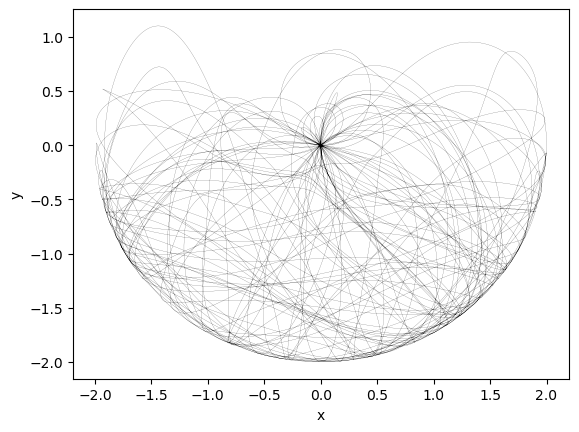

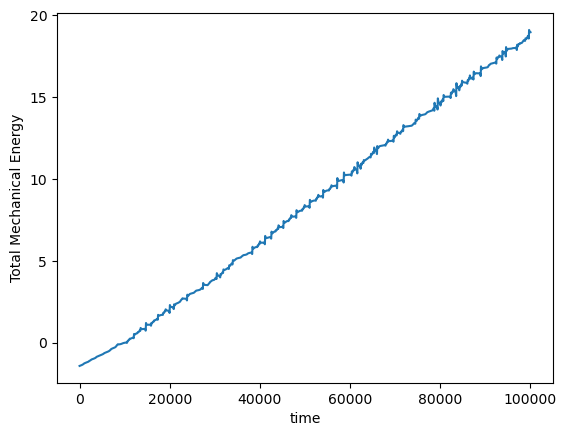

In [43]:
class DoublePendulum:

    def __init__(self, g=9.82, l1=1.0, l2=1.0, m1=1.0, m2=1.0):
        self.g = g
        self.l1 = l1
        self.l2 = l2
        self.m1 = m1
        self.m2 = m2

    def __call__(self, t, x):
        g = self.g
        l1 = self.l1
        l2 = self.l2
        m1 = self.m1
        m2 = self.m2

        theta1, theta2, omega1, omega2 = x

        delta_theta = theta1 - theta2

        denom = (2 * m1 + m2 - m2 * np.cos(2 * delta_theta))

        dtheta1 = omega1
        domega1 = ((-g * (2 * m1 + m2) * np.sin(theta1) - m2 * g * np.sin(theta1 - 2 * theta2) - 2 * np.sin(delta_theta) * m2 * (omega2**2 * l2 + omega1**2 * l1 * np.cos(delta_theta))) / (l1 * denom))

        dtheta2 = omega2
        domega2 = ((2 * np.sin(delta_theta) * (omega1**2 * l1 * (m1 + m2) + g * (m1 + m2) * np.cos(theta1) + omega2**2 * l2 * m2 * np.cos(delta_theta))) / (l2 * denom))

        return np.array([dtheta1, dtheta2, domega1, domega2])
    
    def convert_to_physical(self, y):
        """
        Given a vector of coordinates in the form angle1, angle2, omega1, omega2, 
        convert to physical coordinates of the tips of the pendulums
        """
        l1 = self.l1
        l2 = self.l2
        theta1, theta2 = y[:, 0], y[:, 1]
        x1 = l1 * np.sin(theta1)
        y1 = -l1 * np.cos(theta1)
        x2 = x1 + l2 * np.sin(theta2)
        y2 = y1 - l2 * np.cos(theta2)
        return np.array([x1, y1, x2, y2]).T
    
    def compute_energy(self, y):
        g = self.g
        l1 = self.l1
        l2 = self.l2
        m1 = self.m1
        m2 = self.m2
        theta1, theta2 = y[:, 0], y[:, 1]
        omega1, omega2 = y[:, 2], y[:, 3]
        
        delta_theta = theta1 - theta2

        T = 0.5 * m1 * l1**2 * omega1**2 + 0.5 * m2 * (l1**2 * omega1**2 + l2**2 * omega2**2 + 2 * l1 * l2 * omega1 * omega2 * np.cos(delta_theta))
        U = - m1 * g * l1 * np.cos(theta1) - m2 * g * (l1 * np.cos(theta1) + l2 * np.cos(theta2))
        
        E = T + U
        return E
    
class Euler:
    """The Euler integration scheme"""

    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__

    def integrate(self, f, tspan, y):
        """Integrate the system using the symplectic Euler method"""
        
        m = len(y) // 2
        y_vals = [y.copy()]
        t = tspan[0]
        t_vals = [t]
        while t < tspan[-1]:
            
            yprev = y_vals[-1].copy()
            y_vals.append(yprev + self.dt * f(t, yprev))

            t += self.dt
            t_vals.append(t)

        self.t, self.y = np.array(t_vals), np.array(y_vals)
        return self

pendulum = DoublePendulum()

from scipy.integrate import solve_ivp

# Initial conditions
x0 = np.array([np.pi / 2.1, np.pi / 2, 0.1, 0.2])
t0 = 0.0

# Set up integrator
# integrator = solve_ivp(pendulum, [t0, 40], x0, method='RK45', max_step=1e-3)
# Convert to physical coordinates
# y = pendulum.convert_to_physical(integrator.y.T)
# Set up integrator
integrator = Euler(dt=1e-3)
integrator.integrate(pendulum, [t0, 100], x0)
# Convert to physical coordinates
y = pendulum.convert_to_physical(integrator.y)

plt.figure()
plt.plot(y[:, 2], y[:, 3], 'k', linewidth=0.1)
plt.xlabel('x')
plt.ylabel('y')

plt.figure()
plt.plot(pendulum.compute_energy(integrator.y))
plt.xlabel('time')
plt.ylabel('Total Mechanical Energy')

In [ ]:
# Set up integrator
integrator = solve_ivp(pendulum, [t0, 1000], x0, method='RK45', max_step=1e-3)
# Convert to physical coordinates
y = pendulum.convert_to_physical(integrator.y.T)
# Set up integrator

# Symplectic methods preserve the energy

We can use our knowledge of the existence of a conserved quantity to design an integration scheme that respects the conservation law. Symplectic integrators are variable-step methods, which might have implicit structure if they involve solving a nonlinear Hamiltonian. Here we will implement the symplectic Euler method, which is a first-order method. More sophisticated methods include the Verlet and Leapfrog methods (higher order), and splitting methods.

Suppose that our Hamiltonian describes a harmonic oscillator,
$$
    \mathcal{H}(t, \mathbf{x}, \mathbf{p}) = \frac{1}{2} \mathbf{p}^T \mathbf{p} + \frac{1}{2} \mathbf{x}^T \mathbf{x}
$$

We can write the equations of motion as
$$
    \begin{align}
    \frac{d \mathbf{x}}{dt} &= \mathbf{p} \\
    \frac{d \mathbf{p}}{dt} &= - \mathbf{x}
    \end{align}
$$

<!-- Suppose we perform an Euler update on the position first, -->
<!-- $$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{p}_n
$$

We insert this value into the Hamiltonian, and we solve for the update to the momentum that will preserve the Hamiltonian

$$
\mathcal{H}(t_{n+1}, \mathbf{x}_{n+1}, \mathbf{p}_{n+1}) = \mathcal{H}(t_{n}, \mathbf{x}_{n}, \mathbf{p}_{n}) 
$$

$$
\frac{1}{2} \mathbf{p}_n^T \mathbf{p}_n + \frac{1}{2} \mathbf{x}_n^T \mathbf{x}_n = \frac{1}{2} \mathbf{p}_{n+1}^T \mathbf{p}_{n+1} + \frac{1}{2} \mathbf{x}_{n+1}^T \mathbf{x}_{n+1}
$$

$$
\mathbf{p}_n^T \mathbf{p}_n + \mathbf{x}_n^T \mathbf{x}_n = \mathbf{p}_{n+1}^T \mathbf{p}_{n+1} + (\mathbf{x}_n + \Delta t \, \mathbf{p}_n)^T (\mathbf{x}_n + \Delta t \, \mathbf{p}_n)
$$

$$
\mathbf{p}_{n+1}^T \mathbf{p}_{n+1} = (1 - \Delta t^2) \, \mathbf{p}_n^T \mathbf{p}_n + 2 \Delta t \, \mathbf{p}_n^T \mathbf{x}_n
$$

$$
\mathbf{p}_{n+1} = (1 - \Delta t^2) \,\mathbf{p}_n + 2 \Delta t \, \mathbf{x}_n
$$

$$
\mathbf{p}_{n+1} \approx \mathbf{p}_n + 2 \Delta t \, \mathbf{x}_n
$$

Our update in $\mathbf{p}$ is now explicit.  -->


Suppose we perform an Euler update on the momentum first,

$$
    \mathbf{p}_{n+1} = \mathbf{p}_n - \Delta t \, \mathbf{x}_n
$$

Given this update, we want to calculate an update to the position $\mathbf{x}_{n+1}$ that will preserve the Hamiltonian:
$$
\mathcal{H}(t_{n+1}, \mathbf{x}_{n+1}, \mathbf{p}_{n+1}) = \mathcal{H}(t_{n}, \mathbf{x}_{n}, \mathbf{p}_{n}) 
$$

Inserting our expression, we can solve for the update

$$
\frac{1}{2} \mathbf{p}_n^T \mathbf{p}_n + \frac{1}{2} \mathbf{x}_n^T \mathbf{x}_n = \frac{1}{2} \mathbf{p}_{n+1}^T \mathbf{p}_{n+1} + \frac{1}{2} \mathbf{x}_{n+1}^T \mathbf{x}_{n+1}
$$

$$
\mathbf{p}_n^T \mathbf{p}_n + \mathbf{x}_n^T \mathbf{x}_n = (\mathbf{p}_n - \Delta t \, \mathbf{x}_n)^T (\mathbf{p}_n - \Delta t \, \mathbf{x}_n) + \mathbf{x}_{n+1}^T \mathbf{x}_{n+1}
$$

$$
\mathbf{x}_{n+1}^T \mathbf{x}_{n+1} = \mathbf{p}_n^T \mathbf{p}_n + \mathbf{x}_n^T \mathbf{x}_n - (\mathbf{p}_n - \Delta t \, \mathbf{x}_n)^T (\mathbf{p}_n - \Delta t \, \mathbf{x}_n)
$$

$$
\mathbf{x}_{n+1}^T \mathbf{x}_{n+1} = (1 - \Delta t^2)\mathbf{x}_n^T \mathbf{x}_n + 2\mathbf{p}_n \Delta t \, \mathbf{x}_n^T \mathbf{p}_n 
$$

$$
\mathbf{x}_{n+1} = \mathbf{x}_n - \Delta t^2 \mathbf{x}_n + 2 \Delta t \mathbf{p}_n
$$

$$
\mathbf{x}_{n+1} = \mathbf{x}_n^T \bigg( \mathbf{x}_n + \Delta t (2 \mathbf{p}_n - \Delta t \, \mathbf{x}_n) \bigg)
$$

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{p}_{n+1}
$$


#### Symplectic integration

Energy-conserving integration therefore can be performed by performing the following steps sequentially

$$
    \mathbf{p}_{n+1} = \mathbf{p}_n - \Delta t \, \mathbf{x}_n
$$

$$
    \mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \, \mathbf{p}_{n+1}
$$

Notice that the update for the position is a function of the momentum at the **new** time step, which has already been updated. This is the key difference between symplectic and non-symplectic Euler integration. For a general Hamiltonian, we can write the equations of motion as

$$
\begin{align}
\frac{d \mathbf{x}}{dt} &= \frac{\partial \mathcal{H}}{\partial \mathbf{p}} \\
\frac{d \mathbf{p}}{dt} &= - \frac{\partial \mathcal{H}}{\partial \mathbf{x}}
\end{align}
$$

We can write the Euler update as

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \frac{\partial \mathcal{H}}{\partial \mathbf{p}} \\
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \frac{\partial \mathcal{H}}{\partial \mathbf{x}}
\end{align}
$$




<!-- After a single Euler update step,

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \mathbf{p}_n \\
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \mathbf{f}(\mathbf{x}_{n+1})
\end{align}
$$

In order to preserve the Hamiltonian, we need to update the momentum first, and then the position.

$$
\begin{align}
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \mathbf{f}(\mathbf{x}_{n+1}) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \mathbf{p}_{n+1}
\end{align}
$$



the Hamiltonian is not conserved. However, if we use the same update for $\mathbf{p}$, we get

$$
\begin{align}
\mathbf{x}_{n+1} &= \mathbf{x}_n + \Delta t \, \mathbf{p}_n \\
\mathbf{p}_{n+1} &= \mathbf{p}_n - \Delta t \, \mathbf{f}(\mathbf{x}_{n+1}) \\
\mathbf{x}_{n+2} &= \mathbf{x}_{n+1} + \Delta t \, \mathbf{p}_{n+1} \\
\mathbf{p}_{n+2} &= \mathbf{p}_{n+1} - \Delta t \, \mathbf{f}(\mathbf{x}_{n+2}) \\
\mathbf{x}_{n+3} &= \mathbf{x}_{n+2} + \Delta t \, \mathbf{p}_{n+2} \\
\mathbf{p}_{n+3} &= \mathbf{p}_{n+2} - \Delta t \, \mathbf{f}(\mathbf{x}_{n+3}) \\
\vdots
\end{align}
$$

The Hamiltonian is conserved after every 2 steps. This is called the *leapfrog* method. The leapfrog method is a symplectic integrator.

 -->


In [44]:
class SymplecticEuler:

    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__

    def integrate(self, f, tspan, y):
        """Integrate the system using the symplectic Euler method"""
        
        m = len(y) // 2
        y_vals = [y.copy()]
        t = tspan[0]
        t_vals = [t]
        while t < tspan[-1]:
            
            # yprev = y_vals[-1].copy()
            # y_vals.append(yprev + self.dt * f(t, yprev))

            x0, p0 = y_vals[-1][:m], y_vals[-1][m:]
            # Compute derivatives using the given function f
            dxdt = f(t, np.hstack([x0, p0]))[:m]
            
            # First update positions using the old momenta
            x1 = x0 + self.dt * dxdt
            
            # Now compute new derivatives with the updated positions
            dpdt_new = f(t, np.hstack([x1, p0]))[m:]
            
            # Update momenta using the new derivatives
            p1 = p0 + self.dt * dpdt_new

            y_vals.append(np.hstack((x1, p1)))

            t += self.dt
            t_vals.append(t)

        self.t, self.y = np.array(t_vals), np.array(y_vals)
        return self

Text(0, 0.5, 'Total Mechanical Energy')

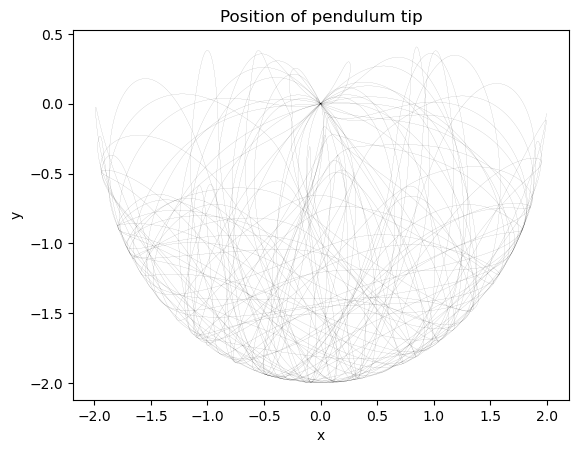

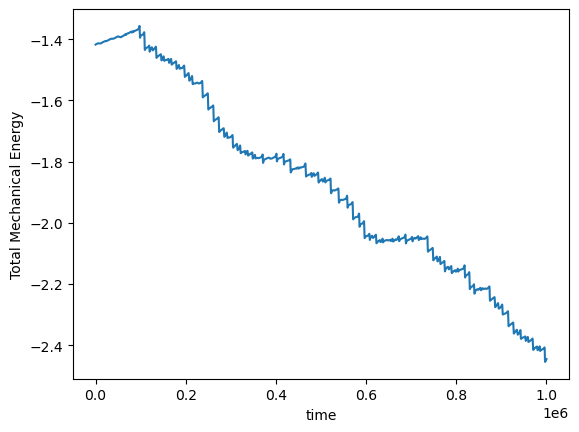

In [45]:
pendulum = DoublePendulum()

# Initial conditions
x0 = np.array([np.pi / 2.1, np.pi / 2, 0.1, 0.2])
t0 = 0.0

# Set up integrator
integrator = SymplecticEuler(dt=1e-4)
integrator.integrate(pendulum, [t0, 100], x0)

# Convert to physical coordinates
y = pendulum.convert_to_physical(integrator.y)

plt.figure()
plt.plot(y[:, 2], y[:, 3], 'k', linewidth=0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Position of pendulum tip")

plt.figure()
plt.plot(pendulum.compute_energy(integrator.y))
plt.xlabel('time')
plt.ylabel('Total Mechanical Energy')